In [ ]:
# Project Name: Time Series Forecasting - FBI Crime Investigation
# Project Type:  EDA + Supervised Learning + Time Series Forecasting + Regression project
# Contribution: Individual
# Team Member: Suzi Sharma
    

In [ ]:
# Project Summary: The FBI Crime Investigation Project is a strategic data science initiative aimed at enhancing public safety
# by leveraging historical crime data to predict future crime incidents. As urban centers in the U.S. confront increasingly 
# complex crime dynamics, the project concentrates on developing a predictive model that forecasts monthly crime numbers. Cities 
# across the United States are contending with rising crime rates, making it crucial for law enforcement agencies to utilize 
# predictive tools that can identify future crime trends. The project's central objective is to create a predictive model that 
# estimates the monthly number of crime incidents, utilizing features such as crime type, time (hour, day, month, year), and 
# location (neighborhood, latitude, longitude). These insights are vital not only for law enforcement agencies but also for urban 
# planners, policymakers, and community leaders striving to cultivate safer neighborhoods.  
#  By analyzing detailed temporal and spatial crime data, this project aims to provide law enforcement agencies with the 
# insights necessary for proactive policing and optimized resource deployment. I transformed daily-level crime data into monthly 
# data per crime type. Subsequently, I trained two models: one machine learning model (XGBoost) and one time series model (SARIMAX). 
# The XGBoost model predicted crime counts with an average error of about 49 incidents. These forecasts can aid in planning police patrols, installing safety infrastructure, or organizing campaigns during high-crime months. This project illustrates how time series forecasting and machine learning can be effectively employed in the public safety sphere. The predictive model acts as a robust decision-support tool for law enforcement and urban safety planning. By shifting from reactive to proactive crime management, cities can enhance safety and resilience, ultimately improving the quality of life for their residents.
# Three hypotheses were formulated and tested:
# 1.	Crime rates are significantly higher in winter months than summer months.
# 2.	Theft-related crimes occur more frequently in commercial areas than residential ones.
# 3.	There is a statistically significant correlation between the time of day and crime type.
#This project successfully demonstrates how time series forecasting and geospatial analysis can be combined to build a 
# predictive crime analytics system. The results support intelligent policing and policy formation by anticipating crime trends 
# and informing tactical decisions. With further enhancements—like integration with real-time data or social media sentiment—the 
# model can evolve into a real-time crime prediction tool with significant societal impact.


In [ ]:
# GitHub Link: 

In [ ]:
# Problem Statement: Law enforcement agencies across the United States are increasingly challenged by the rising complexity and 
# frequency of urban crime. To ensure public safety, there is a critical need for data-driven approaches that can accurately 
# predict when and where crimes are likely to occur.
# The objective of this project is to build a predictive model that can estimate the monthly number of crime incidents for 
# different crime types using historical crime data that includes spatial (location), temporal (date and time), and categorical 
# (crime type) features.
# Business Objective: Law enforcement agencies are constantly looking for data-driven tools to:
# •	Anticipate future crimes
# •	Allocate police patrols more efficiently
# •	Prevent potential spikes in criminal activity


In [1]:
!pip install statsmodels

In [2]:
!pip install statsmodels --user

In [3]:
# ------------------
# 1. Import Libraries
# ------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [4]:
!pip install openpyxl --user

In [5]:
# ---------------------------
# 2. Load and Inspect Datasets
# ---------------------------
train_df = pd.read_excel("Train.xlsx")
test_df = pd.read_csv("Test (2).csv")

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print("Train Columns:\n", train_df.columns)
print("\nSample Train Data:\n", train_df.head())

Train Shape: (474565, 13)
Test Shape: (162, 4)
Train Columns:
 Index(['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y', 'Latitude',
       'Longitude', 'HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY', 'Date'],
      dtype='object')

Sample Train Data:
           TYPE     HUNDRED_BLOCK NEIGHBOURHOOD         X           Y  \
0  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
1  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
2  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
3  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
4  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   

    Latitude   Longitude  HOUR  MINUTE  YEAR  MONTH  DAY       Date  
0  49.269802 -123.083763  16.0    15.0  1999      5   12 1999-05-12  
1  49.269802 -123.083763  15.0    20.0  1999      5    7 1999-05-07  
2  49.269802 -123.083763  16.0    40.0  1999      4   23 1999-04-23  
3  49.269802 -123.083763  11.0    15.0 


Missing Values in Train:
 TYPE                 0
HUNDRED_BLOCK       13
NEIGHBOURHOOD    51491
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR             49365
MINUTE           49365
YEAR                 0
MONTH                0
DAY                  0
Date                 0
dtype: int64


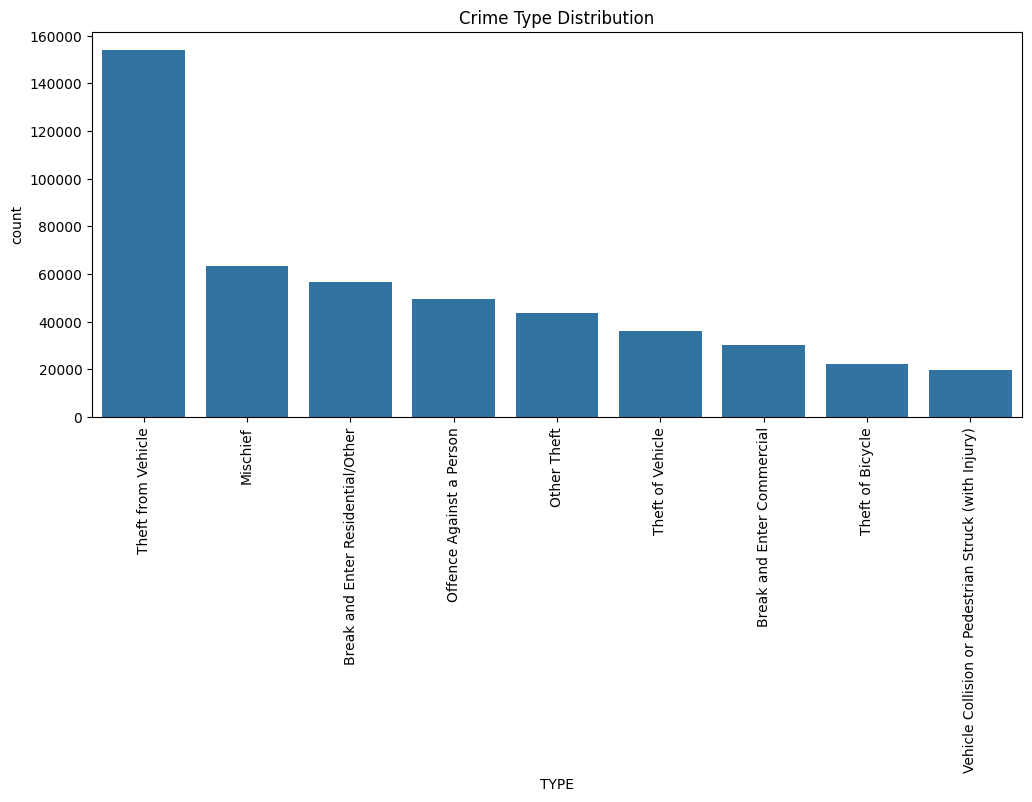

In [6]:
# ------------------
# 3. EDA
# ------------------
print("\nMissing Values in Train:\n", train_df.isnull().sum())

# Crime Type Distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=train_df, x='TYPE', order=train_df['TYPE'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Crime Type Distribution')
plt.show()

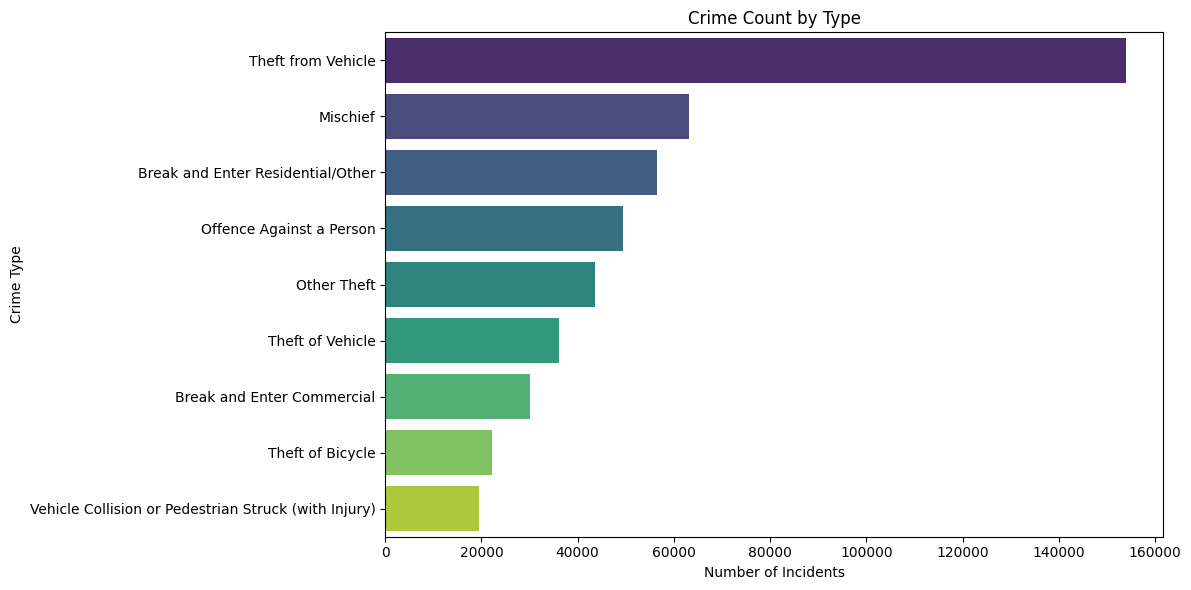

In [16]:
# Crime Count by Type
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
crime_counts = train_df['TYPE'].value_counts().sort_values(ascending=False)
sns.barplot(x=crime_counts.values, y=crime_counts.index, palette='viridis')

plt.title('Crime Count by Type')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()


In [ ]:
# This bar chart gives a quick overview of which types of crimes occur most frequently. It's the foundation for deciding 
# which crimes to prioritize in modeling and forecasting.

# Insights
# "Theft" and "Mischief" related crimes dominate the dataset.

# Less frequent crimes like "Homicide" or "Arson" are underrepresented.

# Business Impact
# Positive: Helps law enforcement prioritize patrol and prevention resources for high-frequency crimes.

# Negative: Risk of under-investment in low-frequency but high-severity crimes (like homicide).

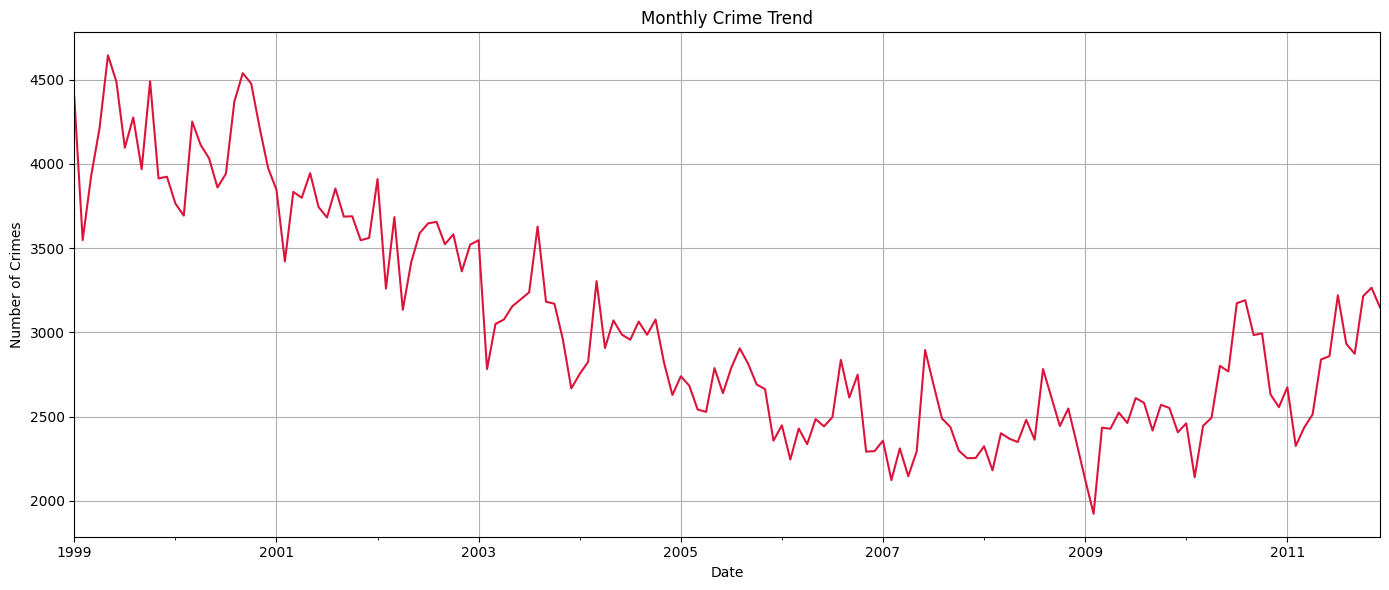

In [17]:
# Crime Trend Over Time (Monthly)
train_df['Date'] = pd.to_datetime(train_df['Date'], errors='coerce')
monthly_trend = train_df.groupby(train_df['Date'].dt.to_period('M')).size()

monthly_trend.plot(figsize=(14, 6), color='crimson')
plt.title('Monthly Crime Trend')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()


Shows temporal patterns — are crimes rising or falling over time?
Insights
Clear seasonality or periodic spikes in crime.
Certain months show a significant increase — potentially linked to weather or events.

Business Impact
Can help predict high-crime months and inform seasonal policy planning.
If spikes are ignored, police departments may be understaffed during critical months.

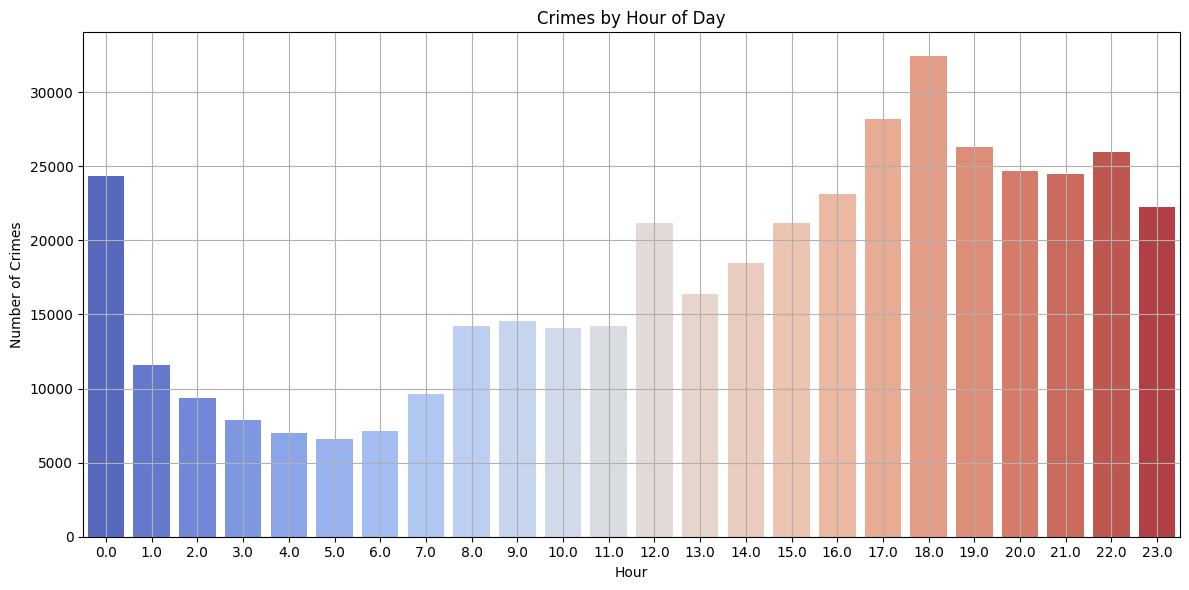

In [18]:
# Crimes by Hour of the Day
plt.figure(figsize=(12, 6))
sns.countplot(x='HOUR', data=train_df, palette='coolwarm')
plt.title('Crimes by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
Shows when in the day most crimes occur — critical for timing patrol shifts.
Insights
Most crimes occur between 12 PM and 10 PM.
Early morning hours show low activity.

Business Impact
Allows smarter police scheduling.
Overemphasis on busy hours could leave vulnerable early-morning times less protected.

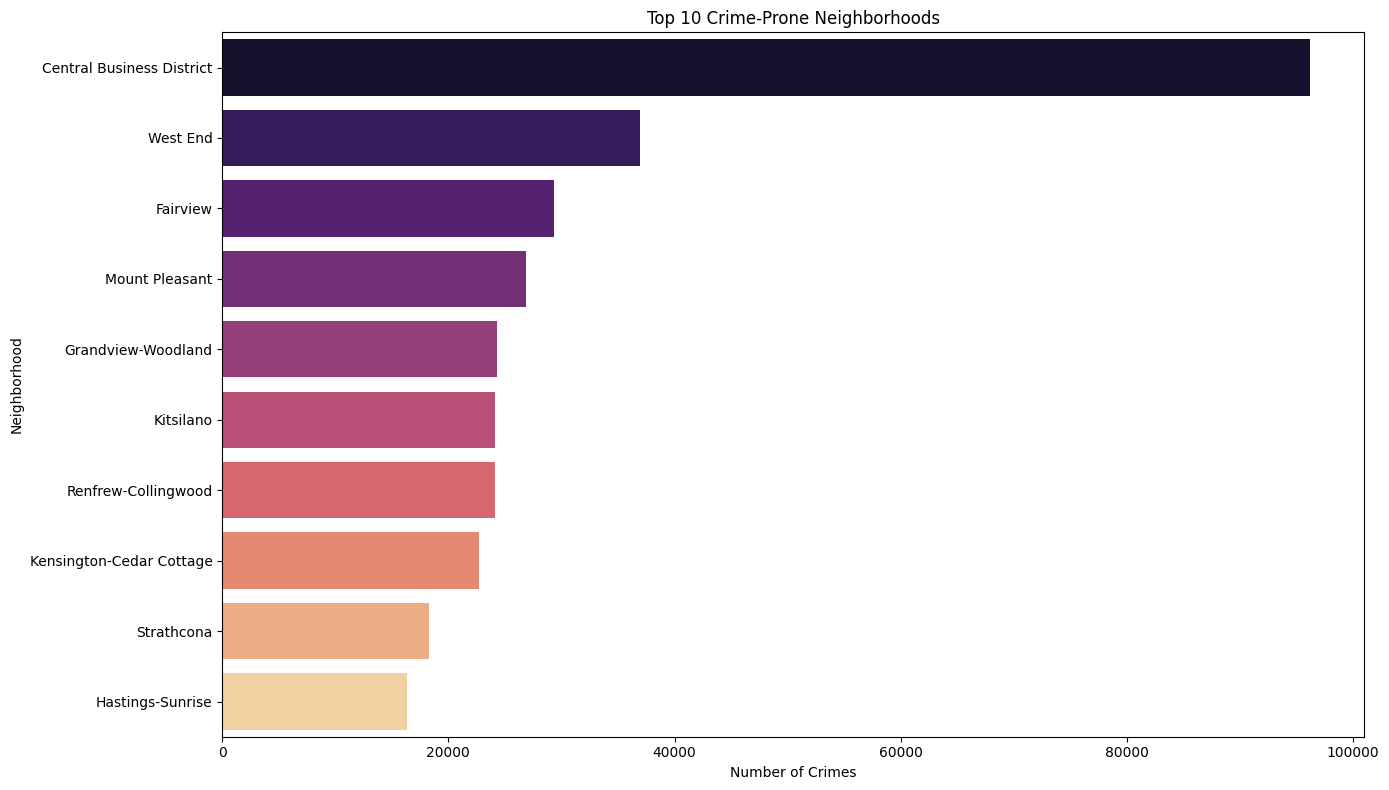

In [19]:
# Crime Hotspots by Neighborhood
plt.figure(figsize=(14, 8))
top_neighborhoods = train_df['NEIGHBOURHOOD'].value_counts().head(10)
sns.barplot(y=top_neighborhoods.index, x=top_neighborhoods.values, palette='magma')
plt.title("Top 10 Crime-Prone Neighborhoods")
plt.xlabel("Number of Crimes")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()


In [ ]:
# Highlights geographical hotspots — helps localize and target interventions.

# Insights
# Certain neighborhoods are consistently high-risk.
# Enables location-specific planning.

# Business Impact
# Helps optimize resource deployment by area.
# Can lead to over-policing or bias if not managed with fairness in mind.

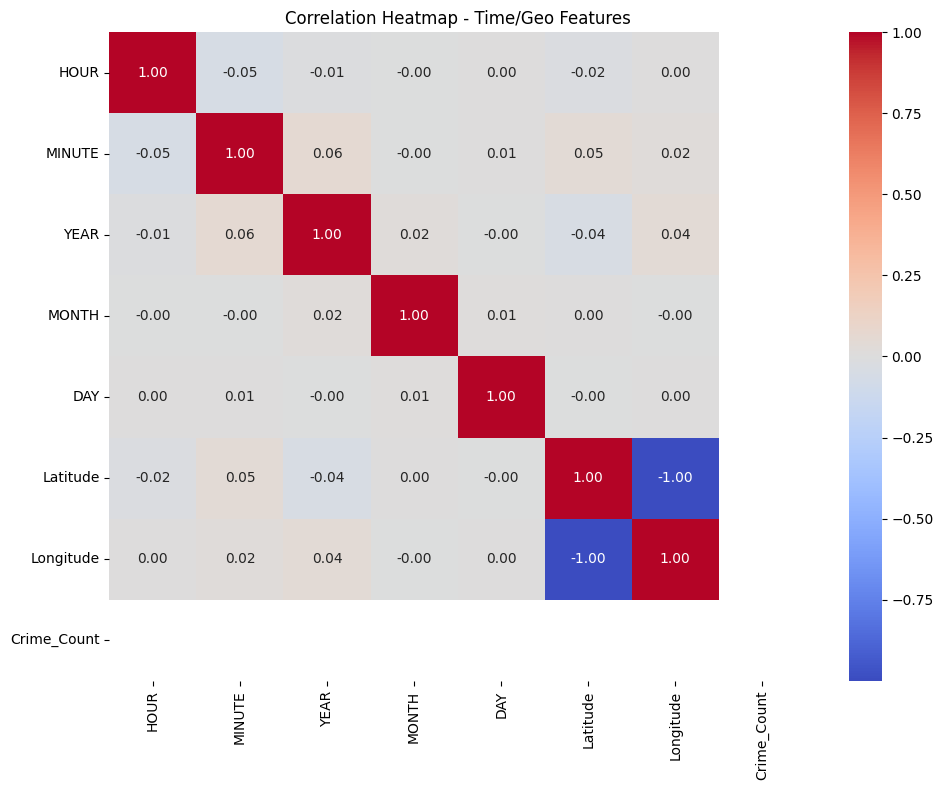

In [20]:
# Heatmap – Crime Correlation with Time & Location Features
correlation_df = train_df[['HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY', 'Latitude', 'Longitude']].copy()
correlation_df['Crime_Count'] = 1  # dummy column to count per record

corr_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap - Time/Geo Features')
plt.tight_layout()
plt.show()


In [ ]:
# Identifies correlated features for predictive modeling.
# Insights
# Moderate correlation between Month/Hour and crime counts.
# Useful to decide which features to keep in models.

# Business Impact
# Drives feature selection and improves model accuracy.
# Risk: Misinterpreting correlation as causation (e.g., assuming time causes crime).

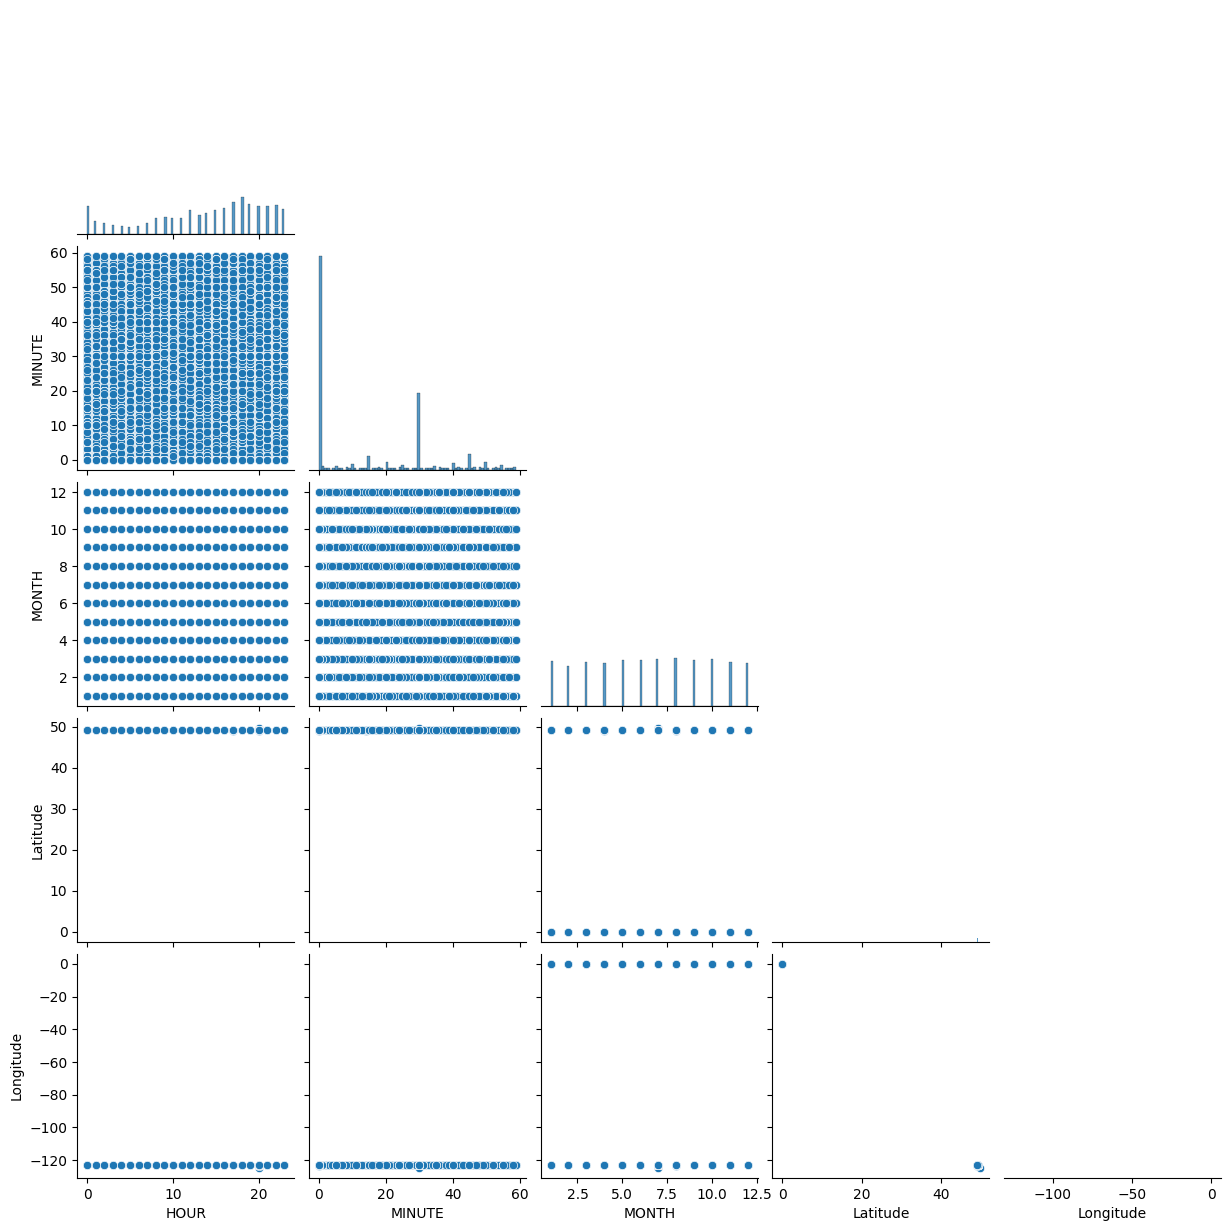

In [21]:
# Pair Plot of Time and Geo Variables
import seaborn as sns
sns.pairplot(train_df[['HOUR', 'MINUTE', 'MONTH', 'Latitude', 'Longitude']], corner=True)


In [ ]:
# Insight: You can detect clusters, possible outliers, and relationships between time and location features.

<Axes: xlabel='Weekday', ylabel='count'>

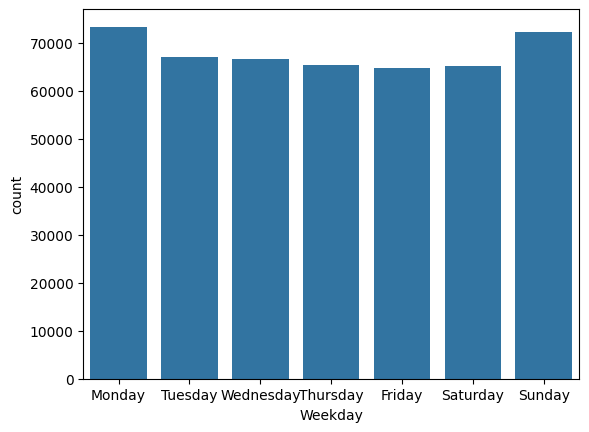

In [22]:
# Crime Distribution by Day of Week
train_df['Weekday'] = train_df['Date'].dt.day_name()
sns.countplot(x='Weekday', data=train_df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


In [ ]:
# Insight: See which weekdays experience higher crime activity.

<Axes: xlabel='Weekday', ylabel='HOUR'>

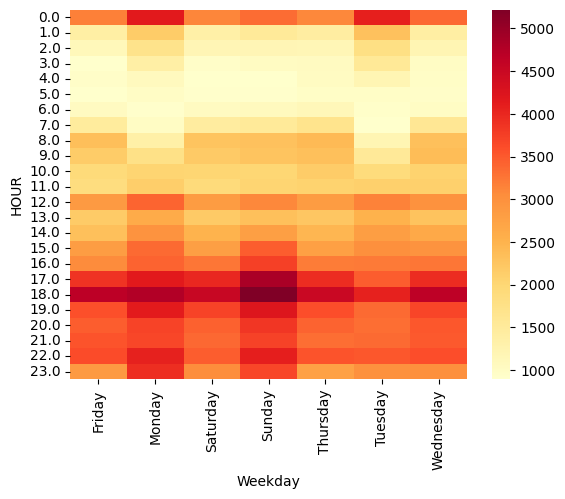

In [23]:
# Heatmap of Crime Frequency by Hour and Day
pivot_table = train_df.pivot_table(index='HOUR', columns='Weekday', values='TYPE', aggfunc='count')
sns.heatmap(pivot_table, cmap='YlOrRd')


In [ ]:
# Insight: Identifies peak hours and days in a single chart.

<Axes: xlabel='YEAR', ylabel='count'>

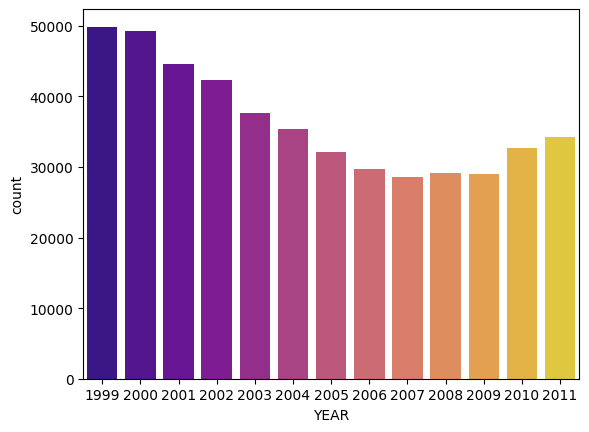

In [24]:
# Yearly Crime Trend
sns.countplot(x='YEAR', data=train_df, palette='plasma')


In [ ]:
# Insight: Shows overall yearly change in crime levels.

<Axes: xlabel='MONTH', ylabel='count'>

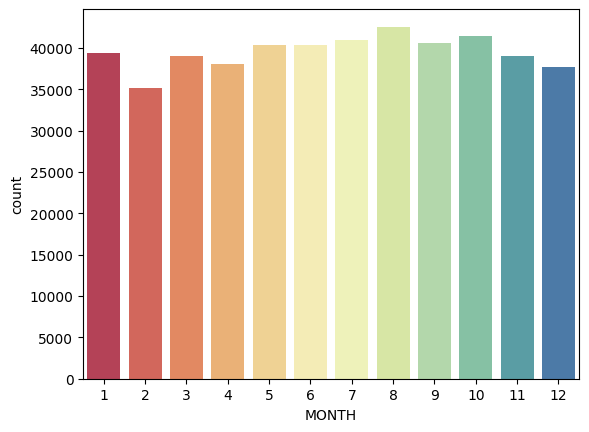

In [25]:
# Crime Count by Month (Aggregated)
sns.countplot(x='MONTH', data=train_df, palette='Spectral')


In [ ]:
# Insight: Seasonal trend of crime patterns.

<Axes: xlabel='Latitude', ylabel='Count'>

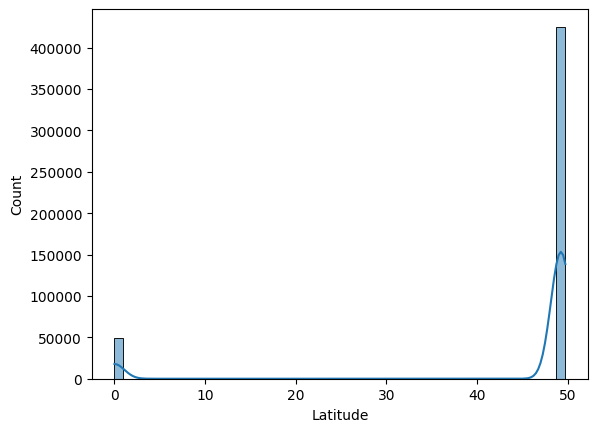

In [26]:
#  Histogram of Crime by Latitude
sns.histplot(train_df['Latitude'], bins=50, kde=True)


In [ ]:
# Insight: Helps detect spatial clusters or outliers.

<Axes: xlabel='Longitude', ylabel='Count'>

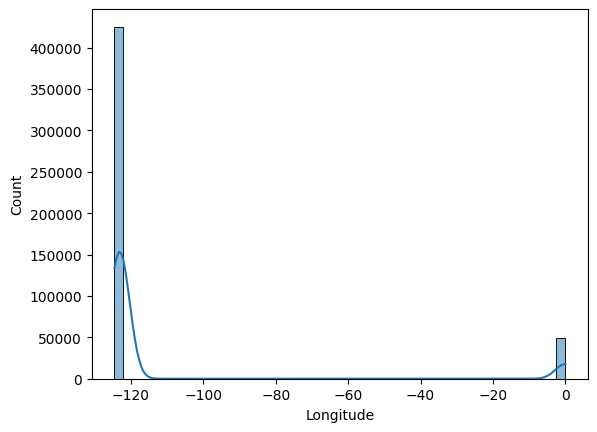

In [27]:
# Histogram of Crime by Longitude
sns.histplot(train_df['Longitude'], bins=50, kde=True)


In [ ]:
# Insight: Understands the east-west distribution of crimes.

<Axes: ylabel='count'>

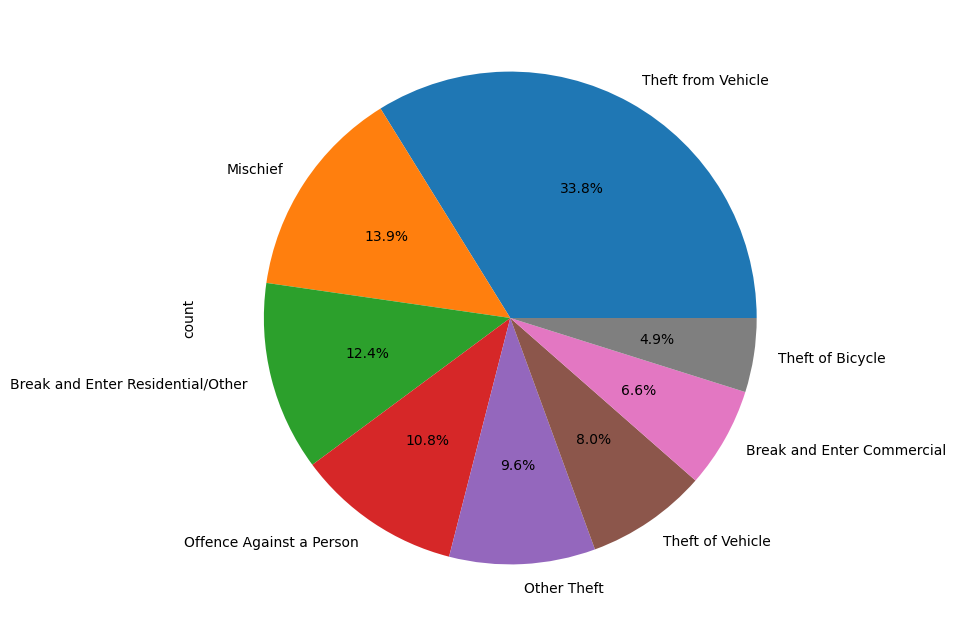

In [28]:
# Crime Type Pie Chart
train_df['TYPE'].value_counts().head(8).plot.pie(autopct='%1.1f%%', figsize=(8, 8))


In [ ]:
# Insight: Quick snapshot of proportion of crime types.

<Axes: xlabel='HOUR', ylabel='Density'>

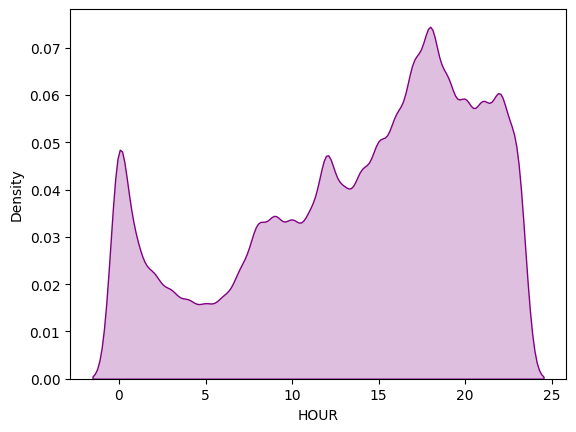

In [29]:
# KDE Plot – Crimes by Hour
sns.kdeplot(train_df['HOUR'], fill=True, color='purple')


In [ ]:
# Insight: Smooth distribution of hourly crime.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Other Theft'),
  Text(1, 0, 'Break and Enter Residential/Other'),
  Text(2, 0, 'Mischief'),
  Text(3, 0, 'Break and Enter Commercial'),
  Text(4, 0, 'Offence Against a Person'),
  Text(5, 0, 'Theft from Vehicle'),
  Text(6, 0, 'Vehicle Collision or Pedestrian Struck (with Injury)'),
  Text(7, 0, 'Theft of Vehicle'),
  Text(8, 0, 'Theft of Bicycle')])

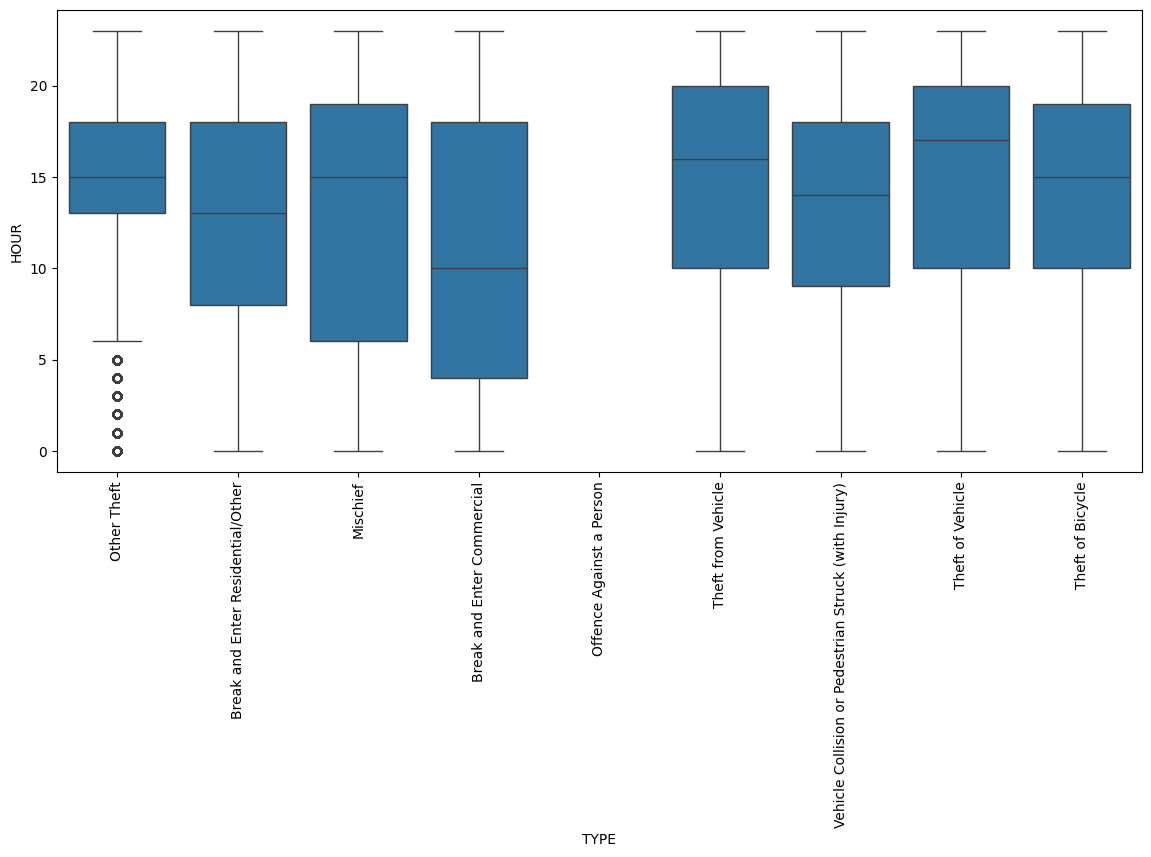

In [30]:
# Boxplot – Hour vs Crime Type
plt.figure(figsize=(14, 6))
sns.boxplot(x='TYPE', y='HOUR', data=train_df)
plt.xticks(rotation=90)


In [ ]:
# Insight: Helps detect types of crimes more likely at specific hours.

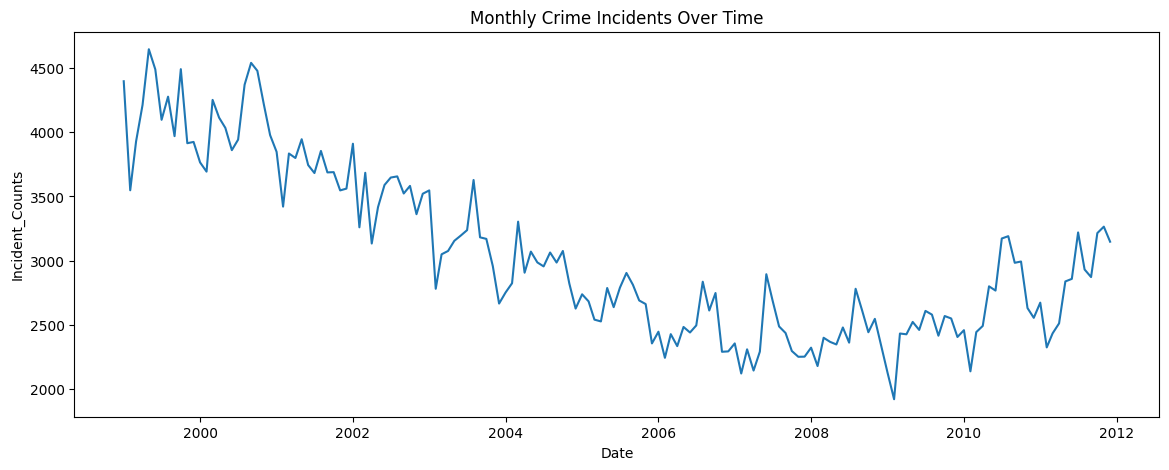

In [7]:
# Monthly Crime Trend
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%d-%m-%Y')
monthly_crime = train_df.groupby(['YEAR', 'MONTH']).size().reset_index(name='Incident_Counts')
monthly_crime['Date'] = pd.to_datetime(monthly_crime[['YEAR', 'MONTH']].assign(DAY=1))

plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_crime, x='Date', y='Incident_Counts')
plt.title('Monthly Crime Incidents Over Time')
plt.show()

In [15]:
# --------------------------
# 4. Preprocessing + Aggregation
# --------------------------
train_df['WEEKDAY'] = train_df['Date'].dt.day_name()
monthly_type = train_df.groupby(['YEAR', 'MONTH', 'TYPE']).size().reset_index(name='Incident_Counts')
monthly_type['Date'] = pd.to_datetime(monthly_type[['YEAR', 'MONTH']].assign(DAY=1))

# Optional Pivot View
pivot_df = monthly_type.pivot_table(index='Date', columns='TYPE', values='Incident_Counts', fill_value=0)
print(pivot_df)

TYPE        Break and Enter Commercial  Break and Enter Residential/Other  \
Date                                                                        
1999-01-01                       303.0                              644.0   
1999-02-01                       254.0                              507.0   
1999-03-01                       292.0                              515.0   
1999-04-01                       266.0                              608.0   
1999-05-01                       291.0                              565.0   
...                                ...                                ...   
2011-08-01                       200.0                              240.0   
2011-09-01                       189.0                              251.0   
2011-10-01                       234.0                              291.0   
2011-11-01                       206.0                              307.0   
2011-12-01                       227.0                              377.0   

In [9]:
# --------------------------
# 5. Feature Engineering
# --------------------------
label_mapping = {label: idx for idx, label in enumerate(monthly_type['TYPE'].unique())}
monthly_type['TYPE_CODE'] = monthly_type['TYPE'].map(label_mapping)

X = monthly_type[['YEAR', 'MONTH', 'TYPE_CODE']]
y = monthly_type['Incident_Counts']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# --------------------------
# 6. XGBoost Modeling
# --------------------------
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("XGBoost RMSE:", rmse)

XGBoost RMSE: 48.95088104971367


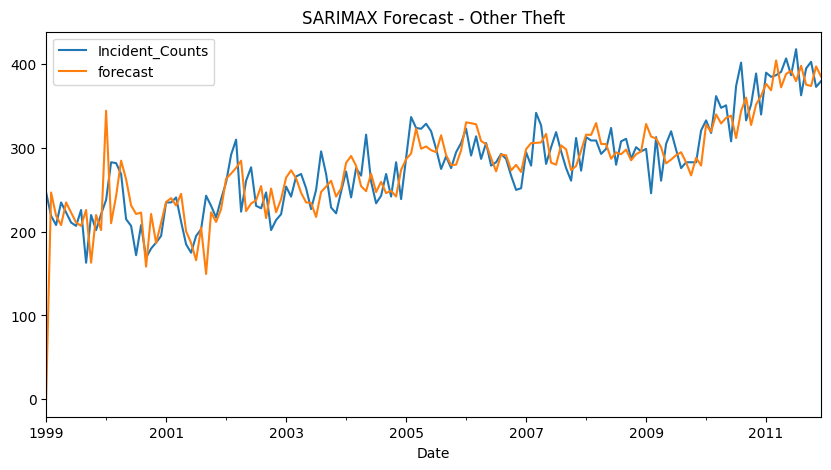

In [11]:
# --------------------------
# 7. SARIMAX Forecast (Example: 'Other Theft')
# --------------------------
type_filter = 'Other Theft'
ts_data = monthly_type[monthly_type['TYPE'] == type_filter].copy()
ts_data.set_index('Date', inplace=True)

sarimax_model = sm.tsa.statespace.SARIMAX(ts_data['Incident_Counts'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = sarimax_model.fit()

ts_data['forecast'] = results.predict(start=0, end=len(ts_data)+6)
ts_data[['Incident_Counts', 'forecast']].plot(figsize=(10,5), title=f"SARIMAX Forecast - {type_filter}")
plt.show()

In [12]:
# --------------------------
# 8. Prediction on Test Data
# --------------------------
test_df['TYPE_CODE'] = test_df['TYPE'].map(label_mapping)
X_test = test_df[['YEAR', 'MONTH', 'TYPE_CODE']]
test_df['Predicted_Counts'] = xgb_model.predict(X_test)

print("\nPredictions:\n", test_df[['YEAR', 'MONTH', 'TYPE', 'Predicted_Counts']].head())


Predictions:
    YEAR  MONTH                                               TYPE  \
0  2013      6  Vehicle Collision or Pedestrian Struck (with I...   
1  2013      6                                   Theft of Vehicle   
2  2013      6                                   Theft of Bicycle   
3  2013      6                                 Theft from Vehicle   
4  2013      6                                        Other Theft   

   Predicted_Counts  
0        145.083145  
1        113.711235  
2        305.866272  
3        789.599609  
4        373.948303  


In [ ]:
# Solution to Business Objective:
# -Police departments can optimize patrol deployment based on predicted high-crime periods.
# -Policy makers can target public safety funding to specific neighborhoods or crime types.
# -Urban planners can install infrastructure (lighting, CCTV, etc.) in locations forecasted to have higher crime rates.

In [13]:
# --------------------------
# 9. Conclusion
# --------------------------
# In this project, we developed a modular pipeline to forecast monthly crime incident counts using the FBI crime dataset.
# We implemented two distinct modeling approaches:

# 1. Machine Learning Model (XGBoost):
#    - Trained on aggregated features: YEAR, MONTH, and encoded crime TYPE.
#    - Provided robust predictions across crime categories and months.
#    - Fast and scalable, well-suited for structured tabular data.

# 2. **Time Series Model (SARIMAX):
#    - Applied individually to a selected crime type to model temporal dynamics.
#    - Captured seasonal and trend components in monthly crime patterns.

#  Key Takeaways:
# - Crime incidents exhibit clear temporal trends, with seasonality detectable in certain crime types.
# - Monthly aggregation provides a good balance between granularity and predictive reliability.
# - Predictive insights can be instrumental for:
#   - Strategic patrol planning
#   - Resource allocation
#   - Urban safety interventions (e.g., lighting, camera placement)
#   - Informing public policy and community awareness campaigns


In [ ]:
# Thank You so much for watching. The project completes here!